<a href="https://colab.research.google.com/github/carlomigs/tensortrade/blob/master/examples/migs_TensorTrade_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import warnings
import numpy

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))

In [2]:
# copy in datasets from btgym
!git clone https://github.com/Kismuz/btgym.git

Cloning into 'btgym'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 7001 (delta 4), reused 8 (delta 2), pack-reused 6977
Receiving objects: 100% (7001/7001), 126.71 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (5172/5172), done.
Checking out files: 100% (348/348), done.


In [3]:
!git clone https://github.com/notadamking/tensortrade.git

Cloning into 'tensortrade'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 3139 (delta 139), reused 176 (delta 101), pack-reused 2881
Receiving objects: 100% (3139/3139), 30.07 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (1833/1833), done.


In [4]:
!pip install -e /content/tensortrade

Obtaining file:///content/tensortrade
     |████████████████████████████████| 17.3MB 2.8MB/s 
     |████████████████████████████████| 10.5MB 28.4MB/s 
     |████████████████████████████████| 1.6MB 37.5MB/s 
     |████████████████████████████████| 266kB 51.6MB/s 
  Created wheel for gym: filename=gym-0.14.0-cp36-none-any.whl size=1637526 sha256=cb8c3caa647c62e86803df373ff5ad48c0e4ea03ef0e4de9503460f8ddb3b61d
  Stored in directory: /root/.cache/pip/wheels/7e/53/f6/c0cd3c9bf953f35c0aee7fa62ea209371e92f5e5cced3245ba
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44104 sha256=5024229b6eb138cbd378a0d849849bc7db0682ae4c13e98385a792204d45e188
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built gym pyyaml
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'

In [1]:
import os
os.getcwd()
#%cd /content/tensortrade
%ls

btgym/  sample_data/  tensortrade/


In [2]:
!pip install -e tensortrade[tf,tensorforce,baselines,ccxt,fbm] -U

Obtaining file:///content/tensortrade
     |████████████████████████████████| 225kB 2.7MB/s 
     |████████████████████████████████| 1.4MB 22.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 317kB 46.1MB/s 
     |████████████████████████████████| 92.5MB 102kB/s 
     |████████████████████████████████| 256kB 42.6MB/s 
     |████████████████████████████████| 1.2MB 33.0MB/s 
     |████████████████████████████████| 2.3MB 30.7MB/s 
     |████████████████████████████████| 3.2MB 35.5MB/s 
     |████████████████████████████████| 368kB 53.8MB/s 
     |████████████████████████████████| 317kB 51.0MB/s 
     |████████████████████████████████| 204kB 47.2MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=20fd057a05d6c1600dffc54b419e58826d698dbf2eae74e8ae76e50ccb5ff079
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
  Fo

In [3]:
!pip install talib-binary

     |████████████████████████████████| 2.4MB 2.8MB/s 


In [0]:
%ls /content/btgym/examples/data/

DAT_ASCII_EURCHF_M1_2017.csv*
DAT_ASCII_EURGBP_M1_2017.csv*
DAT_ASCII_EURJPY_M1_2017.csv*
DAT_ASCII_EURUSD_M1_2010.csv*
DAT_ASCII_EURUSD_M1_2011.csv*
DAT_ASCII_EURUSD_M1_2012.csv*
DAT_ASCII_EURUSD_M1_2013.csv*
DAT_ASCII_EURUSD_M1_2014.csv*
DAT_ASCII_EURUSD_M1_2015.csv*
DAT_ASCII_EURUSD_M1_2016.csv
DAT_ASCII_EURUSD_M1_201701.csv*
DAT_ASCII_EURUSD_M1_201702.csv*
DAT_ASCII_EURUSD_M1_201703_1_10.csv
DAT_ASCII_EURUSD_M1_201703.csv*
DAT_ASCII_EURUSD_M1_201704.csv*
DAT_ASCII_EURUSD_M1_201705.csv*
DAT_ASCII_EURUSD_M1_201706.csv*
DAT_ASCII_EURUSD_M1_2017.csv*
test_bent_sine_1min_period1500_300_delta0002.csv
test_bent_sine_1min_period_300_1500_delta0002.csv
test_sine_1min_period256_delta0002.csv


In [85]:
import numpy
import pandas as pd
from tensortrade.exchanges.simulated import SimulatedExchange

headers=['datetime', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('/content/btgym/examples/data/DAT_ASCII_EURUSD_M1_2017.csv',
                 delimiter=';',
                 names=headers)

exchange = SimulatedExchange(data_frame=df, base_instrument='USD', pretransform=True)
exchange.data_frame.tail()

,open,high,low,close,volume
371630,1.19972,1.19987,1.19972,1.19987,0
371631,1.19985,1.19985,1.19970,1.19970,0
371632,1.19969,1.20014,1.19961,1.20010,0
371633,1.20009,1.20023,1.19974,1.19983,0
371634,1.19982,1.20074,1.19980,1.20005,0


In [86]:
from tensortrade.features import FeaturePipeline
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features.indicators import SimpleMovingAverage

price_columns = ["open", "high", "low", "close"]

normalize_price = MinMaxNormalizer(price_columns, inplace=True)
moving_averages = SimpleMovingAverage(price_columns)
difference_all = FractionalDifference(difference_order=1, inplace=True)

feature_pipeline = FeaturePipeline(steps=[normalize_price,
                                          moving_averages,
                                          difference_all])
exchange.feature_pipeline = feature_pipeline
exchange.data_frame.tail()

,open,high,low,close,volume
371630,4.000000e-12,9.500000e-12,4.500000e-12,1.150000e-11,0.0
371631,1.050000e-11,4.000000e-12,3.500000e-12,-3.500000e-12,0.0
371632,-2.500000e-12,1.800000e-11,-6.500000e-12,1.600000e-11,0.0
371633,1.550000e-11,1.350000e-11,-2.000000e-12,-2.500000e-12,0.0
371634,-2.000000e-12,4.300000e-11,1.000000e-12,9.500000e-12,0.0


In [0]:
from tensortrade.actions import DiscreteActionStrategy

#action_strategy = DiscreteActionStrategy(n_actions=20, instrument_symbol='BTC')
action_strategy = DiscreteActionStrategy(n_actions=20)

In [0]:
from tensortrade.rewards import SimpleProfitStrategy
from tensortrade.rewards import RiskAdjustedReturnStrategy

reward_strategy = SimpleProfitStrategy()
#reward_strategy = RiskAdjustedReturnStrategy()

In [0]:
from tensortrade.environments import TradingEnvironment

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy)

In [0]:
environment.exchange.transform_data_frame()

In [0]:
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines import PPO2

model = PPO2
policy = MlpLnLstmPolicy
params = { "learning_rate": 1e-5, 'nminibatches': 1 }

## Training a Strategy

Creating our trading strategy is as simple as plugging in our agent and the environment.

MigsStableBaselinesTradingStrategy

In [0]:
#@title
import os
import gym
import json

import pandas as pd
import numpy as np

from abc import ABCMeta, abstractmethod
from typing import Union, Callable, List, Dict

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import BasePolicy
from stable_baselines.common.base_class import BaseRLModel
from stable_baselines import DQN

from tensortrade.environments.trading_environment import TradingEnvironment
from tensortrade.strategies import TradingStrategy


class MigsStableBaselinesTradingStrategy(TradingStrategy):
    """A trading strategy capable of self tuning, training, and evaluating with stable-baselines."""

    def __init__(self,
                 environment: TradingEnvironment,
                 model: BaseRLModel = DQN,
                 policy: Union[str, BasePolicy] = 'MlpPolicy',
                 model_kwargs: any = {},
                 **kwargs):
        """
        Arguments:
            environment: A `TradingEnvironment` instance for the agent to trade within.
            model (optional): The RL model to create the agent with. Defaults to DQN.
            policy (optional): The RL policy to train the agent's model with. Defaults to 'MlpPolicy'.
            model_kwargs (optional): Any additional keyword arguments to adjust the model.
            kwargs (optional): Optional keyword arguments to adjust the strategy.
        """
        self._model = model
        self._model_kwargs = model_kwargs

        self.environment = environment
        self._agent = self._model(policy, self._environment, **self._model_kwargs)

    @property
    def environment(self) -> 'TradingEnvironment':
        """A `TradingEnvironment` instance for the agent to trade within."""
        return self._environment

    @environment.setter
    def environment(self, environment: 'TradingEnvironment'):
        self._environment = DummyVecEnv([lambda: environment])

    def restore_agent(self, path: str):
        """Deserialize the strategy's learning agent from a file.
        Arguments:
            path: The `str` path of the file the agent specification is stored in.
        """
        self._agent = self._model.load(path, self._environment, self._model_kwargs)

    def save_agent(self, path: str):
        """Serialize the learning agent to a file for restoring later.
        Arguments:
            path: The `str` path of the file to store the agent specification in.
        """
        self._agent.save(path)

    def tune(self, steps: int = None, episodes: int = None, callback: Callable[[pd.DataFrame], bool] = None) -> pd.DataFrame:
        raise NotImplementedError

    def run(self, steps: int = None, episodes: int = None, episode_callback: Callable[[pd.DataFrame], bool] = None) -> pd.DataFrame:
        if steps is None and episodes is None:
            raise ValueError(
                'You must set the number of `steps` or `episodes` to run the strategy.')

        steps_completed = 0
        episodes_completed = 0
        average_reward = 0

        obs, state, dones = self._environment.reset(), None, [False]

        performance = {}

        while (steps is not None and (steps == 0 or steps_completed < steps)) or (episodes is not None and episodes_completed < episodes):
            actions, state = self._agent.predict(obs, state=state, mask=dones)
            obs, rewards, dones, info = self._environment.step(actions)

            steps_completed += 1
            average_reward -= average_reward / steps_completed
            average_reward += rewards[0] / (steps_completed + 1)

            exchange_performance = info[0].get('exchange').performance
            performance = exchange_performance if len(exchange_performance) > 0 else performance

            if dones[0]:
                #if episode_callback is not None and episode_callback(performance):
                #    break
                episodes_completed += 1
                print("episode #: {}".format(episodes_completed))
                print(performance[-2:])
                obs = self._environment.reset()

        print("Finished running strategy.")
        print("Total episodes: {} ({} timesteps).".format(episodes_completed, steps_completed))
        print("Average reward: {}.".format(average_reward))

        return performance

In [0]:
#from tensortrade.strategies import StableBaselinesTradingStrategy

strategy = MigsStableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

Then to train the strategy (i.e. train the agent on the current environment), all we need to do is call `strategy.run()` with the total number of steps or episodes you’d like to run.

If this feedback loop is a bit slow for you, you can pass a callback function to `run`, which will be called at the end of each episode. The callback function will pass in a `data_frame` containing the agent's performance that episode, and expects a `bool` in return. If `True`, the agent will continue training, otherwise, the agent will stop and return its overall performance.

In [0]:
#performance = strategy.run(steps=100000)
performance = strategy.run(episodes=3, episode_callback=True)

episode #: 1
       balance  net_worth
2365  5.930891  10.083227
2366  7.974855  10.051718
episode #: 2
        balance  net_worth
2352   9.937687  10.075105
2353  10.006156  10.074857
episode #: 3
       balance  net_worth
2347  4.385997  10.063393
2348  8.596292  10.015410
Finished running strategy.
Total episodes: 3 (9759 timesteps).
Average reward: -0.7086708115673862.


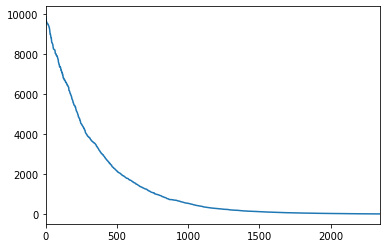

In [0]:
%matplotlib inline
performance.net_worth.plot()

## BTC

In [0]:
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import FBMExchange
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features import FeaturePipeline
from tensortrade.rewards import SimpleProfitStrategy
from tensortrade.actions import DiscreteActionStrategy
from tensortrade.strategies import StableBaselinesTradingStrategy

normalize = MinMaxNormalizer(inplace=True)
difference = FractionalDifference(difference_order=0.6,
                                  inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize, difference])

reward_strategy = SimpleProfitStrategy()
action_strategy = DiscreteActionStrategy(n_actions=20)
                                         #, instrument_symbol='ETH/BTC')

exchange = FBMExchange(base_instrument='BTC',
                       timeframe='1h',
                       pretransform=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy,
                                 feature_pipeline=feature_pipeline)

strategy = StableBaselinesTradingStrategy(environment=environment)

In [82]:
performance = strategy.run(episodes=100)

Finished running strategy.
Total episodes: 100 (166500 timesteps).
Average reward: -0.7075384953545519.


In [83]:
performance[-5:]

,balance,net_worth
18,10011.541763,10051.022679
19,10041.778297,10051.887473
20,10046.904752,10052.046647
21,10049.568773,10052.240812
22,10050.891627,10052.218457


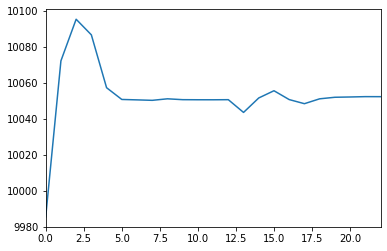

In [84]:
%matplotlib inline
performance.net_worth.plot()

In [18]:
%ls /content/tensortrade/examples/data/

Coinbase_BTCUSD_1h.csv  configuration.json
Coinbase_BTCUSD_d.csv   configuration.yaml


In [24]:
import pandas as pd
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import SimulatedExchange
df = pd.read_csv('/content/tensortrade/examples/data/Coinbase_BTCUSD_1h.csv',skiprows=1)
exchange = SimulatedExchange(data_frame=df, 
                             base_instrument='BTC',
                             feature_pipeline=feature_pipeline)
environment = TradingEnvironment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy)
new_strategy.environment = environment
test_performance = new_strategy.run(steps=2000)

TypeError: ignored

## Saving and Restoring

All trading strategies are capable of saving their agent to a file, for later restoring. The environment is not saved, as it does not have state that we care about preserving. To save our `TensorflowTradingStrategy` to a file, we just need to provide the path of the file to our strategy.

In [0]:
print(os.getcwd())
%ls

/content/tensortrade
CODE_OF_CONDUCT.md  examples/    README.md         tensortrade/
CONTRIBUTING.md     LICENSE      requirements.txt  tensortrade.egg-info/
Dockerfile          Makefile     setup.cfg         tests/
docs/               MANIFEST.in  setup.py


In [0]:
strategy.save_agent(path="ppo_btc_1h")

_This specific strategy saves multiple files, including a directory of models to the path provided._

To restore the agent from the file, we first need to instantiate our strategy, before calling restore_agent.

In [0]:
new_strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

new_strategy.restore_agent(path="ppo_btc_1h")

Our strategy is now restored back to its previous state, and ready to be used again. Let's see how it does.

## Tuning Your Strategy

Sometimes a trading strategy will require tuning a set of hyper-parameters, or features, on an environment to achieve maximum performance. In this case, each `TradingStrategy` provides an optionally implementable tune method.

Tuning a model is similar to training a model, however in addition to adjusting and saving the weights and biases of the best performing model, the strategy also adjusts and persists the hyper-parameters that produced that model. 

In [0]:
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import FBMExchange

exchange = FBMExchange(timeframe='1h', base_instrument='BTC', feature_pipeline=feature_pipeline)
environment = TradingEnvironment(exchange=exchange, 
                                 action_strategy=action_strategy, 
                                 reward_strategy=reward_strategy) 
new_strategy.environment = environment 
tuned_performance = new_strategy.tune(episodes=10)

NotImplementedError: ignored

In this case, the agent will be trained for 10 episodes, with a different set of hyper-parameters each episode. The best set will be saved within the strategy, and used any time strategy.run() is called thereafter.

## Strategy Evaluation

Now that we've tuned and trained our agent, it's time to see how well it performs. To evaluate our strategy's performance on unseen data, we will need to run it on a new environment backed by such data.

In [0]:
import pandas as pd
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import SimulatedExchange

df = pd.read_csv('/content/tensortrade/examples/data/Coinbase_BTCUSD_d.csv', skiprows=1)
exchange = SimulatedExchange(data_frame=df,
                             feature_pipeline=feature_pipeline,
                             base_instrument='USD',
                             should_pretransform_obs=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_strategy=action_strategy,
                                 reward_strategy=reward_strategy)

new_strategy.environment = environment

test_performance = new_strategy.run(steps=2000)

Finished running strategy.
Total episodes: 1 (2000 timesteps).
Average reward: -0.6791065948644133.


In [0]:
df.tail()

,date,symbol,open,high,low,close,volume_btc,volume
1765,2014-12-05,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00
1766,2014-12-04,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1767,2014-12-03,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1768,2014-12-02,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1769,2014-12-01,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53


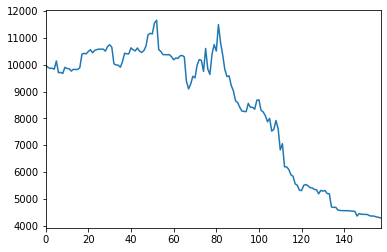

In [0]:
%matplotlib inline

test_performance.net_worth.plot()

When complete, strategy.run returns a `Pandas.data_frame` of the agent's performance, including the net worth and balance of the agent at each time step.

## Live Trading

Once you've built a profitable trading strategy, trained an agent to trade it properly, and ensured its "generalize-ability" to new data sets, all there is left to do is profit. Using a live exchange such as `CCXTExchange`, you can plug your strategy in and let it run!

While the gambler in you may enjoy starting a strategy and letting it run without bounds, the more risk averse of you can use a `trade_callback`, which will be called each time the strategy makes a trade. This callback function, similar to the episode callback, will pass in a data frame containing the agent's overall performance, and expects a `bool` in return. If `True`, the agent will continue trading, otherwise, the agent will stop and return its performance over the session.

In [0]:
import ccxt
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.live import CCXTExchange

binance = ccxt.binance({
    'apiKey': 'HfPX38sJ2aKewYDUJx6TaWrDhuT7rq426elO5Gbc55Dvg4klASEfm0aqcdl4Mpz6',
    'secret': 'aGdMMaaol3GkyzDcrSEoc4aFlWG78qCxnGl3o22ub24u2scrZRcsIe2qn0kI82GQ',
    'enableRateLimit': True,
})

exchange = CCXTExchange(exchange=binance,
                        base_instrument='BNB',
                        observation_type='ohlcv',
                        timeframe='1h')

btcusd_actions = DiscreteActionStrategy(n_actions=20, instrument_symbol='BNB/BTC')

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_strategy=btcusd_actions,
                                 reward_strategy=reward_strategy)

strategy.environment = environment

live_performance = strategy.run(steps=1)

InvalidOrder: ignored

In [0]:
live_performance

{}

_Passing `steps=0` instructs the strategy to run until otherwise stopped._

https://colab.research.google.com/drive/1r9I-DJjrT-0JHbrB10NLFudZ7hQdOcdq